In [1]:
import acquire
import prepare
import model
import explore

import cbpro
import quantstats as qs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)

# Predicting cryptocurrency returns using machine learning models

## Summary

I compared the forecasting ability of regression and classification models to predict returns for Bitcoin, Ethereum, and Litecoin.  I developed a pipeline for ingesting price data from the Coinbase online API, cleaning the data in preparation for modeling, determining useful features via statistical testing and visualization, and iterating through multiple models to ultimately come up with profitable trading strategies. I roughly followed the methodology used by Helder Sebastiao and Pedro Godinho in their article "Forecasting and trading cryptocurrencies with machine learning under changing market conditions," published 06 Jan 2021 (https://rdcu.be/cMaLB). Though I did not find that the features used in the study showed correlation with Bitcoin returns based on visualization and statistical testing, using them as inputs to the machine learning models did result in positive average returns. Model performance using standard train/validate/test data splitting was superior to single-step forecasting (that used in the study).

# Data Acquisition and Preparation

###  Acquire Bitcoin Data Using Coinbase Pro API (account and API key required) or cached csv

In [2]:
data = acquire.get_data_from_csv()

### Prepare Data:
- Data came from Coinbase without any missing values
- The minimum low value for the BTC and ETH dataset was suspiciously low. Further investigation found that there were system maintenance issues on 2017-04-15 with Coinbase and a flash crash on Ethereum on 2017-06-21. Because the low value is used to calculate a feature, 1-minute data was acquired for that day and the actual low determined and filled in for the erroneous value. Of course if this model was actually deployed on those days it would have affected performance (assuming the low value was used as an input feature) so events like these need to be accounted for prior to any deployment (another project!).

In [3]:
prepared_data = prepare.prepare_crypto_data(data)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15
Corrected eth low data for 2017-06-21


### Bitcoin Price Exploration

### Split into train, validate, test

In [4]:
split_data = prepare.split_datasets(prepared_data, 0.5, 0.3)

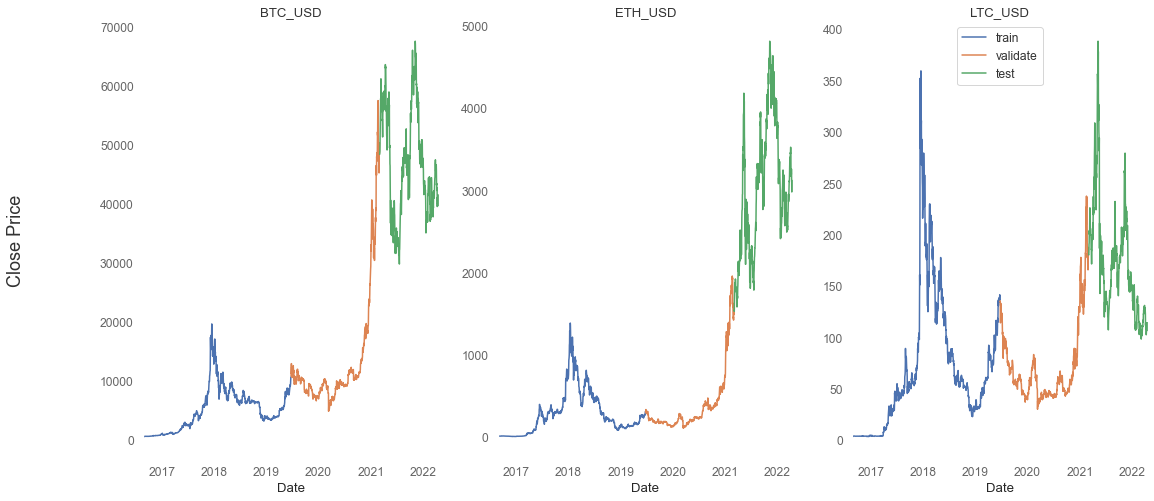

In [5]:
fig, ax = plt.subplots(1,3, figsize=(18,8))
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.close.plot(label='train', ax=ax[i])
    validate.close.plot(label='validate', ax=ax[i])
    test.close.plot(label='test', ax=ax[i])
    ax[i].set_title(f'{k}')
    ax[i].grid(False)
    ax[i].set_xlabel('Date')
plt.legend()
fig.supylabel('Close Price', fontsize = 18)

None

In [6]:
summary_df=pd.DataFrame()
for k in split_data.keys():
    train, validate, test = split_data[k]
    
    summary_df = pd.concat([summary_df, explore.get_summary_statistics(summary_df, train, 'fwd_log_ret',index_name = f'train_{k}')])
    summary_df = pd.concat([summary_df, explore.get_summary_statistics(summary_df, validate, 'fwd_log_ret',index_name = f'validate_{k}')])
    summary_df = pd.concat([summary_df, explore.get_summary_statistics(summary_df, test, 'fwd_log_ret',index_name = f'test_{k}')])

In [7]:
summary_df

,mean,median,min,max,sd,iqr,skewness,excess_kurtosis,autocorrelation
train_BTC_USD,0.283637,0.311017,-17.067595,24.060603,4.193510,0.033026,0.053670,3.710479,-0.011510
validate_BTC_USD,0.241331,0.192699,-49.122610,17.807628,4.280663,0.035989,-2.286196,29.250919,-0.130142
test_BTC_USD,-0.047526,0.020542,-15.423099,13.555753,3.799290,0.042522,-0.163279,1.665123,-0.051122
train_ETH_USD,0.322166,0.000000,-28.246635,28.209701,5.845470,0.051574,0.373165,3.290676,0.003265
validate_ETH_USD,0.260089,0.246431,-56.779363,23.475140,5.294273,0.048438,-2.062388,22.886080,-0.127193
test_ETH_USD,0.159483,0.455333,-32.308051,23.329013,5.033917,0.056281,-0.553625,5.059371,-0.076408
train_LTC_USD,0.345554,-0.094857,-30.795083,60.698111,6.523377,0.052895,1.857457,13.334966,-0.015309
validate_LTC_USD,0.046693,0.017720,-47.819531,23.365639,5.319542,0.049604,-1.103964,11.688585,-0.088275
test_LTC_USD,-0.125704,0.158261,-45.478664,26.173885,5.753980,0.058655,-1.267938,10.626365,-0.081086


### Differences in split samples:
- All currencies have declining mean daily return from train -> validate -> test
    - For BTC and LTC the average return is negative in the test set
    - ETH average return is still quite positive
- Double digit min and max returns
- High SD for all, though LTC appears to be highest followed by ETH then BTC. BTC more stable?
- Excess kurtosis is positive for all, meaning tails are fatter than normal distribution. Greater number and/or more extreme outliers than normal
    - BTC and ETH follow a similar pattern -> lower kurtosis on train and test split up by very high kurtosis on validate. 
    - LTC has had consistently high kurtosis throughout. 

### Target exploration:
- Regression target is forward log returns, which is the difference in close from tomorrow to today
- Classification target is whether next close is positive
- Log returns used (vs absolute prices) so can compare between different time series

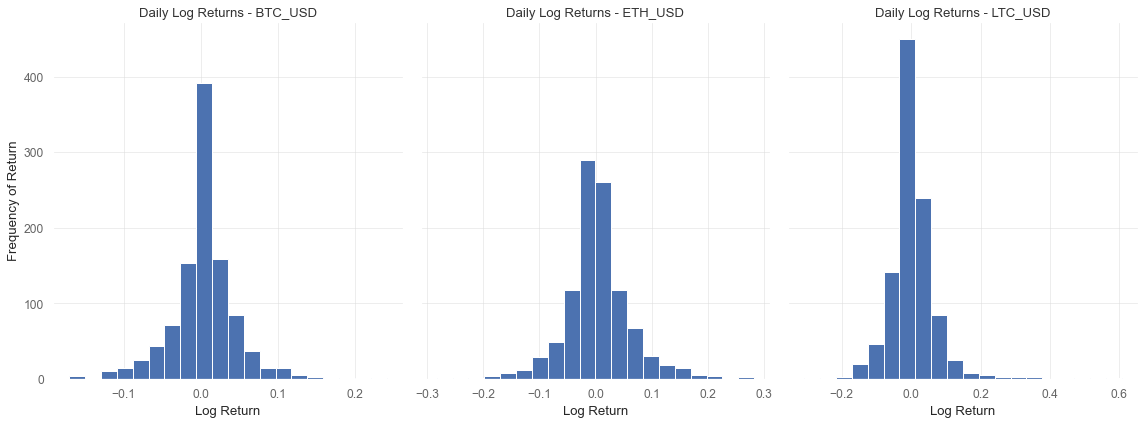

In [8]:
figure, ax = plt.subplots(1,3, sharey = True, figsize = (16, 6), )
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.fwd_log_ret.hist(bins=20, ax=ax[i])
    ax[i].set_title(f'Daily Log Returns - {k}')
    ax[i].set_xlabel('Log Return')
    ax[0].set(ylabel='Frequency of Return')
figure.tight_layout()

Of the three currencies, BTC shows the most normal looking distribution. LTC's high variability, max value, and skew are reflected in its histogram. 

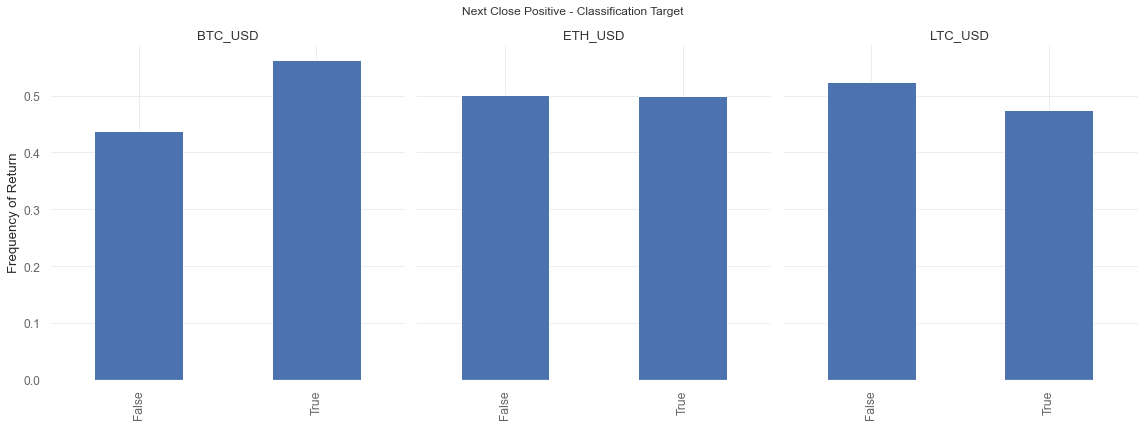

In [9]:
figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.fwd_close_positive.value_counts(normalize=True).sort_index().plot.bar(ax=ax[i], )
    ax[i].set_title(f'{k}')
    ax[0].set(ylabel='Frequency of Return')
plt.suptitle('Next Close Positive - Classification Target')
figure.tight_layout()


All three currencies have fairly balanced distribution, with ETH nearly perfectly split.

### Are there any differences in log returns based on the day of the week or the month of the year?
- Because this is looking at forward log returns it is actually looking at the following day's return

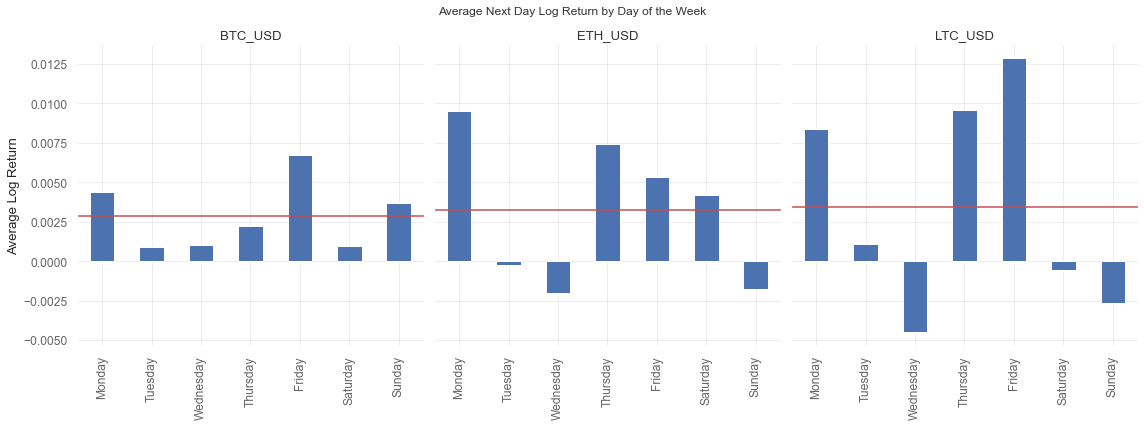

In [10]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.groupby(train.index.day_name()).fwd_log_ret.mean().loc[order].plot.bar(ax=ax[i])
    ax[i].axhline(train.fwd_log_ret.mean(), color = 'r')
    ax[i].set_title(f'{k}')
    ax[i].set(ylabel='Average Log Return', xlabel = '')
plt.suptitle('Average Next Day Log Return by Day of the Week')
figure.tight_layout()

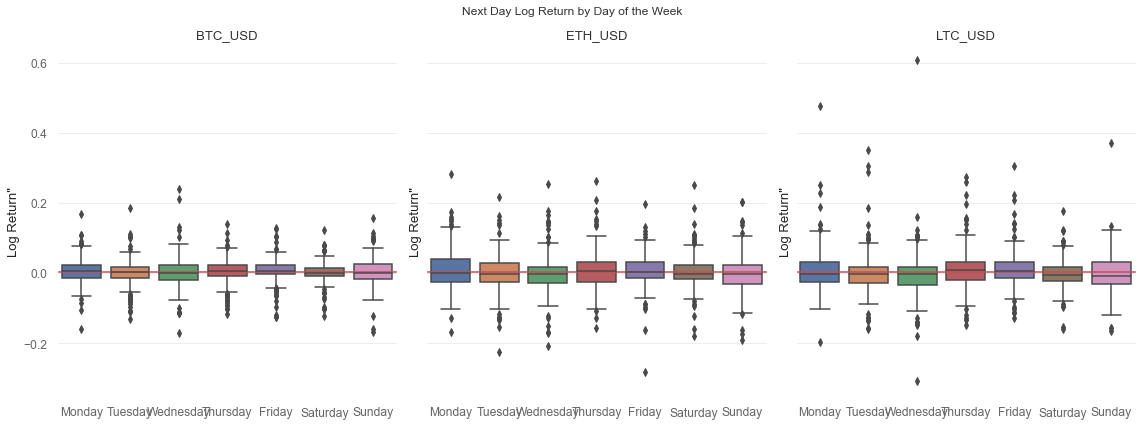

In [11]:
figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    sns.boxplot(x=train.index.day_name(), y = train.fwd_log_ret, order = order, ax = ax[i])
    ax[i].axhline(train.fwd_log_ret.mean(), color = 'r')
    ax[i].set_title(f'{k}')
    ax[i].set(ylabel='Log Return"', xlabel = '')
plt.suptitle('Next Day Log Return by Day of the Week')
figure.tight_layout()

In [12]:
# Set alpha to 0.05
alpha = 0.05

# Perform t-test to determine if any day's average return is significantly different from overall average
for k in split_data.keys():
    train, validate, test = split_data[k]
    overall_mean = train.fwd_log_ret.mean()
    print("--------")
    print(k, overall_mean)
    
    for day_of_the_week in train.index.day_name().unique():
        sample = train[train.index.day_name() == day_of_the_week]
        t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
        if p<alpha:
            print(day_of_the_week, t, p<alpha)
    

--------
BTC_USD 0.002836367346679163
--------
ETH_USD 0.003221663744579549
--------
LTC_USD 0.003455536943860779
Friday 1.9869590522405343 True


LTC Friday is the only day demonstrating higher than average returns based on the t-test

Text(0.5, 0.98, 'Average Next Day Log Return by Month')

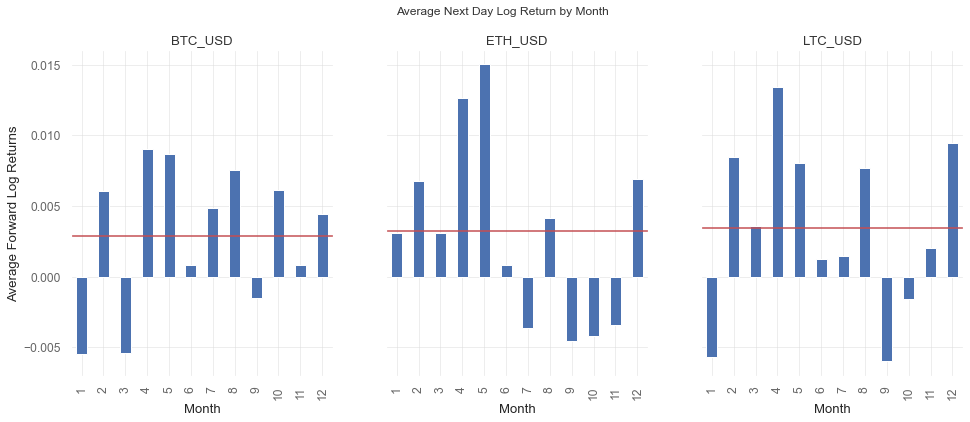

In [13]:
figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))

for i,k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.groupby(train.index.month).fwd_log_ret.mean().plot.bar(ax=ax[i])
    ax[i].axhline(train.fwd_log_ret.mean(), color = 'r')
    ax[i].set_xlabel('Month')
    ax[i].set_ylabel('Average Forward Log Returns')
    ax[i].set_title(k)
plt.suptitle('Average Next Day Log Return by Month')

In [14]:
for k in split_data.keys():
    train,_,_ = split_data[k]
    overall_mean = train.fwd_log_ret.mean()
    print("-----")
    print(k)
    for month_of_year in train.index.month.unique():
        sample = train[train.index.month == month_of_year]
        t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
        if p<alpha:
            print(month_of_year, t, p<alpha)

-----
BTC_USD
3 -2.0085106074230747 True
-----
ETH_USD
10 -2.3653171713388796 True
-----
LTC_USD


### Takeaways:
- All days exhibit positive log returns for the next day on average for Bitcoin. ETH and LTC have at least 3 negative return days.
- There is wide variation depending on the day of the week though, suggesting day of the week matters when it comes to predicting returns
- Notwithstanding the above bullet, the only day with statistically significant above average return is with LTC on Friday.
- No month except March for Bitcoin and October for Ethereum exhibits average returns significantly different from the overall mean

### Does the target exhibit seasonal tendencies?

### Features vs target

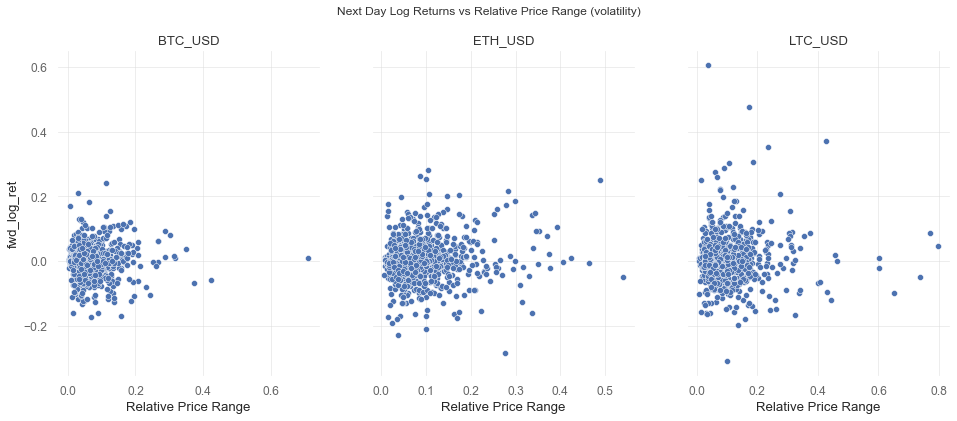

In [15]:
figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))

for i,key in enumerate(split_data.keys()):
    train, _, _ = split_data[key]
    sns.scatterplot(train.RR, train.fwd_log_ret, ax = ax[i])
    ax[i].set_title(f'{key}') 
    ax[i].set_xlabel('Relative Price Range')
    plt.suptitle('Next Day Log Returns vs Relative Price Range (volatility)')
    # plt.show()

### Correlations of features vs target

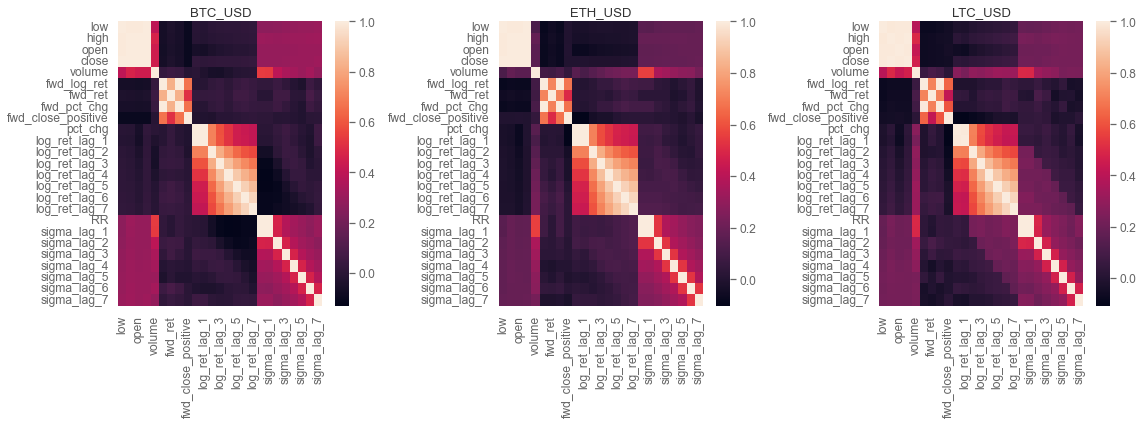

In [16]:
fig, ax = plt.subplots(1,3, figsize=(16,6))
for i,k in enumerate(split_data.keys()):
    train,_,_ = split_data[k]
    sns.heatmap(train[[col for col in train.columns if 'day_name' not in col]].corr(), ax = ax[i])
    ax[i].set_title(k)
fig.tight_layout()

## Exploration Summary:
- Average log returns vary widely depending on the day of the week and month of the year
    - Daily dummies are included as modeling inputs
- No features exhibit strong correlation with the regression target

# Modeling

- 12 different models were used to test the predictability of bitcoin prices:
    - 6 Regression models: Decision Tree Regressor, Random Forest Regressor, SVR, LinearRegression, Tweedie Regressor, and LassoLars 
        - For SVR the non-default hyperparameters used were kernel='linear' and gamma=0.1
        - For Random Forest Regressor and Decision Tree Regressor non-default hyperparameters used were max_depth = 5 and min_samples_leaf=5
        - For all other models default hyperparameters from Scikit-Learn were used
    - 6 Classification models: 
        - Logistic Regression: C=0.1 and C=1
        - Decision Tree Classifier 
        - Random Forest Classifier: max depth of 5
        - KNeighbors Classifier: n_neighbors=10 
        - SVC: linear kernel
- The regression and classification models were evaluated using both the traditional train, validate, test split used for exploration above as well as a rolling window approach for single-step forecasting.
- In addition to the standard RMSE and Accuracy score metrics an average trade was calculated and used to determine the best performance on validate for later use on the withheld test set.
    - Average trade was calculated as follows:
        - For regression models, long trade used for positive sign, short trade used for negative sign
        - For classification models, long trade used for True, short trade used for False
        - The trade is assumed to be opened on the prediction day's close and closed on the next day's close, so return is: (tomorrow's close - today's close) for long trade and (today's close - tomorrow's close) for short trades
- No transaction costs were considered
- Separate baseline methodologies were used for comparing regression and classification model results, though the actual baseline values were equivalent:
    - Regression: Entering long on every close and exiting at the next close
    - Classification: Using the mode of the target (fwd_close_positive) from the train set, which was True, as the prediction for every value. Therefore this also resulted in entering long on every close and exiting at the next close.

### Using Regression and Classification Models

#### Features to be used as inputs:
- log returns lagged by 1-7 days
- Relative Price Range (RR) volatility indicator (for t lags 1-7):
    - 2$\frac{H_t-L_t}{H_t+L_t}$
- Parkinson range volatility estimator $\sigma$ (for t lags 1-7):
    - $\sigma$ = $\sqrt{\frac{(ln(H_t/L_t))^2}{(4*ln(2))}}$
- Day of the week dummy variables

In [17]:
# All available features are used to start
features_to_use = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday']
# List of features to scale (everything except categorical day names)
features_to_scale = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7']

In [18]:
reg_models = [DecisionTreeRegressor(max_depth = 3,min_samples_leaf=5),  
              SVR(kernel='linear',gamma=0.1), 
              LinearRegression(), 
              TweedieRegressor(), 
              LassoLars(),
                RandomForestRegressor(max_depth = 3,min_samples_leaf=5)]
class_models = [LogisticRegression(C=0.1),
                LogisticRegression(C=1),
                DecisionTreeClassifier(max_depth=3),
                KNeighborsClassifier(n_neighbors=10), 
               RandomForestClassifier(max_depth=3),
                SVC(kernel='linear')]

In [19]:
reg_validate_results, class_validate_results, conventional_split_model_results = model.conventional_split(split_data, reg_models, class_models, features_to_use, features_to_scale)

Train/validate: BTC_USD
Train/validate: ETH_USD
Train/validate: LTC_USD


In [20]:
conventional_split_model_results.sort_values(by='pct_avg_trade', ascending=False).head(20)

,avg_trade,pct_avg_trade,validate_rmse,train_rmse,validate_accuracy,train_accuracy,dropoff
LogisticRegression(C=1)_LTC_USD,0.524061,0.006330,NaN,NaN,0.573506,0.584705,-0.019153
LogisticRegression(C=0.1)_LTC_USD,0.502832,0.005859,NaN,NaN,0.576737,0.578896,-0.003731
LassoLars_ETH_USD,2.036963,0.003999,0.052904,0.058426,NaN,NaN,-0.094525
baseline_reg_ETH_USD,1.988242,0.003964,NaN,NaN,NaN,NaN,NaN
baseline_class_ETH_USD,1.988242,0.003964,NaN,NaN,0.532258,0.499516,0.065548
SVC(kernel='linear')_LTC_USD,0.400243,0.003847,NaN,NaN,0.542811,0.563408,-0.036557
TweedieRegressor_BTC_USD,75.541906,0.003738,0.042724,0.041739,NaN,NaN,0.023609
"SVR(gamma=0.1, kernel='linear')_LTC_USD",0.273511,0.003675,0.055096,0.065409,NaN,NaN,-0.157677
LinearRegression_LTC_USD,0.409466,0.003578,0.053135,0.064905,NaN,NaN,-0.181332
RandomForestClassifier(max_depth=3)_BTC_USD,54.988271,0.003384,NaN,NaN,0.527419,0.582769,-0.094976


#### For the conventional (50/30/20) data split, the following are the best models for each cryptocurrency (when sorted by percent average trade):
- Logistic Regression with C=1 is best for LTC (0.006330% average trade) but exhibits high dropoff in accuracy from train to validate. Thus C=0.1 would be preferred as it is the next best in terms of average percent trade but has about 1/5 of the dropoff in accuracy.
- LassoLars with default hyperparameters is best for Ethereum, but it is only slightly above the baseline (0.003964% average trade)
- Tweedie Regressor is best for Bitcoin, with an average percent trade of 0.003738%

## Alternative data split - perform modeling using one-step ahead forecasting (rolling window)
- Each log return in validate is predicted using a model trained on the preceding 1033 observerations (length of train)
- After making the prediction the first row used for train is removed and the last validate row is added to the train set
- The result is a prediction for each validate day that is compared to the actual value of log return
- Hyperparameters are tuned using the validate set, with the best performing model on validate used for every day in test
- Test is predicted one day at a time

### Regression models - single step forecasting

In [21]:
res_df = model.rolling_reg_models(split_data, reg_models, 'fwd_log_ret', features_to_use, features_to_scale)

testing BTC_USD DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
DecisionTreeRegressor(max_depth=3, min_samples_leaf=5) avg validate rmse 0.04408873435645517521-03-02
testing BTC_USD SVR(gamma=0.1, kernel='linear')
SVR(gamma=0.1, kernel='linear') avg validate rmse 0.04616229903464747621-03-02
testing BTC_USD LinearRegression()
LinearRegression avg validate rmse 0.0430038970612822- 2021-03-02
testing BTC_USD TweedieRegressor()
TweedieRegressor avg validate rmse 0.04281912693314511 2021-03-02
testing BTC_USD LassoLars()
LassoLars avg validate rmse 0.0428684732596698662021-03-02
testing BTC_USD RandomForestRegressor(max_depth=3, min_samples_leaf=5)
RandomForestRegressor(max_depth=3, min_samples_leaf=5) avg validate rmse 0.04312745350245720421-03-02
testing ETH_USD DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
DecisionTreeRegressor(max_depth=3, min_samples_leaf=5) avg validate rmse 0.05433606633608173421-03-02
testing ETH_USD SVR(gamma=0.1, kernel='linear')
SVR(gamma=0.1, ke

In [22]:
reg_model_results_df = model.consolidate_rolling_reg(res_df)

### Classification modeling - single step forecasting

In [27]:
# Performing single step modeling
target = 'fwd_close_positive'
class_res_df = model.rolling_class_models(split_data, class_models, target, features_to_use, features_to_scale)

BTC_USD LogisticRegression(C=0.1) validate accuracy 0.503225806451612902
BTC_USD LogisticRegression(C=1) validate accuracy 0.504838709677419402
BTC_USD DecisionTreeClassifier(max_depth=3) validate accuracy 0.485483870967741902
BTC_USD KNeighborsClassifier(n_neighbors=10) validate accuracy 0.520967741935483902
BTC_USD RandomForestClassifier(max_depth=3) validate accuracy 0.501612903225806402
BTC_USD SVC(kernel='linear') validate accuracy 0.483870967741935502
ETH_USD LogisticRegression(C=0.1) validate accuracy 0.540322580645161302
ETH_USD LogisticRegression(C=1) validate accuracy 0.525806451612903202
ETH_USD DecisionTreeClassifier(max_depth=3) validate accuracy 0.506451612903225802
ETH_USD KNeighborsClassifier(n_neighbors=10) validate accuracy 0.511290322580645102
ETH_USD RandomForestClassifier(max_depth=3) validate accuracy 0.512903225806451602
ETH_USD SVC(kernel='linear') validate accuracy 0.519354838709677502
LTC_USD LogisticRegression(C=0.1) validate accuracy 0.541195476575121102
LTC

In [28]:
# Consolidate results of modeling into dataframe
class_model_results_df = model.consolidate_rolling_class(class_res_df)

In [29]:
class_model_results_df

,avg_trade,pct_avg_trade,train_accuracy,validate_accuracy,dropoff
LogisticRegression(C=0.1)_BTC_USD_single_step,0.061537,0.001195,0.590343,0.541195,-0.083252
baseline_single_step,-0.084709,-0.001921,0.508885,0.508885,0.000000
LogisticRegression(C=1)_BTC_USD_single_step,0.095388,0.001915,0.591678,0.547658,-0.074400
DecisionTreeClassifier(max_depth=3)_BTC_USD_single_step,-0.045485,0.000528,0.592066,0.512116,-0.135035
KNeighborsClassifier(n_neighbors=10)_BTC_USD_single_step,-0.173544,-0.001770,0.648182,0.495961,-0.234843
RandomForestClassifier(max_depth=3)_BTC_USD_single_step,-0.235356,-0.001774,0.644838,0.520194,-0.193296
SVC(kernel='linear')_BTC_USD_single_step,0.078463,0.001724,0.571729,0.534733,-0.064708
LogisticRegression(C=0.1)_ETH_USD_single_step,0.061537,0.001195,0.590343,0.541195,-0.083252
baseline_single_step,-0.084709,-0.001921,0.508885,0.508885,0.000000
LogisticRegression(C=1)_ETH_USD_single_step,0.095388,0.001915,0.591678,0.547658,-0.074400


#### Consolidate all results into one dataframe

In [46]:
every_model_results = conventional_split_model_results.append(class_model_results_df).append(reg_model_results_df).sort_values(by=['pct_avg_trade','dropoff'], ascending=[False, True])
every_model_results.head(40)

,avg_trade,pct_avg_trade,validate_rmse,train_rmse,validate_accuracy,train_accuracy,dropoff
LogisticRegression(C=1)_LTC_USD,0.524061,0.006330,NaN,NaN,0.573506,0.584705,-0.019153
LogisticRegression(C=0.1)_LTC_USD,0.502832,0.005859,NaN,NaN,0.576737,0.578896,-0.003731
LassoLars_ETH_USD,2.036963,0.003999,0.052904,0.058426,NaN,NaN,-0.094525
baseline_class_ETH_USD,1.988242,0.003964,NaN,NaN,0.532258,0.499516,0.065548
baseline_reg_ETH_USD,1.988242,0.003964,NaN,NaN,NaN,NaN,NaN
SVC(kernel='linear')_LTC_USD,0.400243,0.003847,NaN,NaN,0.542811,0.563408,-0.036557
TweedieRegressor_BTC_USD,75.541906,0.003738,0.042724,0.041739,NaN,NaN,0.023609
"SVR(gamma=0.1, kernel='linear')_LTC_USD",0.273511,0.003675,0.055096,0.065409,NaN,NaN,-0.157677
LinearRegression_LTC_USD,0.409466,0.003578,0.053135,0.064905,NaN,NaN,-0.181332
RandomForestClassifier(max_depth=3)_BTC_USD,54.988271,0.003384,NaN,NaN,0.527419,0.582769,-0.094976


### Takeaways after Validate:
- Same top models for each cryptocurrency as reported earlier with traditional split.
    - Logistic Regression with C=1 is best for LTC (0.006330% average trade) but exhibits greater dropoff from train to validate. Thus C=0.1 would be preferred as it is the next best in terms of average percent trade but has about 1/5 of the dropoff in accuracy.
    - LassoLars with default hyperparameters (alpha = 1.0) is best for Ethereum, but it is only slightly above the baseline (0.003964% average trade)
    - Tweedie Regressor is best for Bitcoin, with an average percent trade of 0.003738%
- Single Step forecasting did worse than nearly every model forecasting using the standard train/validate/test split method, which is surprising. Only 3 single step models cracked the top 20.
- Most models did worse than the baselines.
- Higher accuracy and lower RMSE scores did not always result in a better performing model on an average trade basis.


### Testing Logistic Regression on Test set:

#### Litecoin

In [31]:
models = [LogisticRegression(C=0.1)]

# Setup y_test for regression target
y_train = split_data['LTC_USD'][0][['fwd_close_positive']]
y_test = split_data['LTC_USD'][2]['fwd_close_positive']
accuracies_train, accuracies_test, y_train, y_test = model.predict_classification(models, split_data['LTC_USD'][0], split_data['LTC_USD'][2], split_data['LTC_USD'][2], features_to_use, features_to_scale, perform_feature_selection=False)

avg_trade, test_results =  model.calculate_classification_results(models, accuracies_train, accuracies_test, split_data['LTC_USD'][2], y_test)

avg_trade

,avg_trade,pct_avg_trade,validate_accuracy,train_accuracy
baseline_class,-0.176981,0.000359,0.516908,0.475315
LogisticRegression(C=0.1),0.011913,-0.000655,0.492754,0.578896


Accuracy drops from 58% to 49% and average trade is negative. Not encouraging results.

Text(0, 0.5, 'Cumulative Equity')

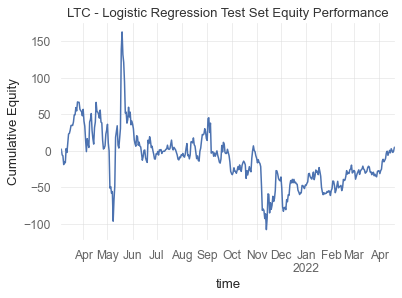

In [32]:
test_results['LogisticRegression(C=0.1)_ret'].cumsum().plot()
plt.title('LTC - Logistic Regression Test Set Equity Performance')
plt.ylabel('Cumulative Equity')

Pretty much breakeven for LTC

#### Ethereum

In [33]:
models = [LassoLars()]

# Setup y_test for regression target
y_train = split_data['ETH_USD'][0][['fwd_log_ret']]
y_test = split_data['ETH_USD'][2]['fwd_log_ret']
accuracies_train, accuracies_test, y_train, y_test = model.predict_regression(models, split_data['ETH_USD'][0], split_data['ETH_USD'][2], split_data['ETH_USD'][2], features_to_use, features_to_scale, perform_feature_selection=False, num_features=0)

avg_trade, test_results =  model.calculate_regression_results(models, accuracies_train, accuracies_test, split_data['ETH_USD'][2], y_test)

avg_trade

,avg_trade,pct_avg_trade,validate_rmse,train_rmse
LassoLars,3.496973,0.002863,0.050305,0.058426
baseline_reg,3.478406,0.002852,NaN,NaN


Text(0, 0.5, 'Cumulative Equity')

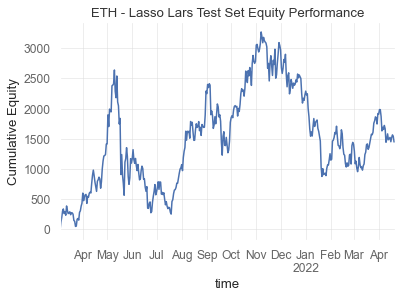

In [34]:
test_results['LassoLars_ret'].cumsum().plot()
plt.title('ETH - Lasso Lars Test Set Equity Performance')
plt.ylabel('Cumulative Equity')

RMSE actually improved and cumulative equity fairly good though quite volatile!

#### Bitcoin

In [35]:
models = [TweedieRegressor()]

# Setup y_test for regression target
y_train = split_data['BTC_USD'][0][['fwd_log_ret']]
y_test = split_data['BTC_USD'][2]['fwd_log_ret']
accuracies_train, accuracies_test, y_train, y_test = model.predict_regression(models, split_data['BTC_USD'][0], split_data['BTC_USD'][2], split_data['BTC_USD'][2], features_to_use, features_to_scale, perform_feature_selection=False, num_features=0)

avg_trade, test_results =  model.calculate_regression_results(models, accuracies_train, accuracies_test, split_data['BTC_USD'][2], y_test)

avg_trade

,avg_trade,pct_avg_trade,validate_rmse,train_rmse
TweedieRegressor,-2.355860,0.000408,0.038135,0.041693
baseline_reg,-20.867464,0.000243,NaN,NaN


Text(0, 0.5, 'Cumulative Equity')

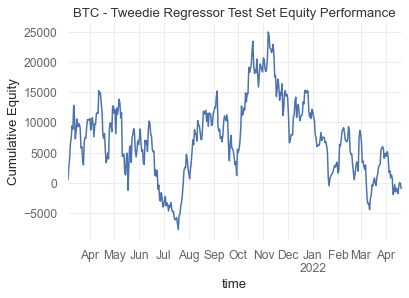

In [36]:
test_results['TweedieRegressor_ret'].cumsum().plot()
plt.title('BTC - Tweedie Regressor Test Set Equity Performance')
plt.ylabel('Cumulative Equity')

Average return goes way down but RMSE also decreases. RMSE clearly not indicative of trade performance.

### Plot equity curve during validation period for a model

In [ ]:
lreq = reg_validate_results['BTC_USD']['LassoLars_ret'].cumsum()

base = split_data['BTC_USD'][1].fwd_ret.cumsum()

val_df = pd.DataFrame(index = validate.index)
val_df['lr_equity'] = lreq
val_df['btc'] = base

val_df.plot()

In [ ]:
# Sharpe Ratio

ret = class_validate_results['LTC_USD']['LogisticRegression(C=1)_ret']
pct_ret = class_validate_results['LTC_USD']['LogisticRegression(C=1)_pct_ret']

sharpe = pct_ret.mean()*(365**0.5)/pct_ret.std()

print("Sharpe", sharpe)

sortino = pct_ret.mean()*(365**0.5)/(pct_ret[pct_ret<0].std())

print("Sortino",sortino)

In [ ]:
print(qs.stats.sharpe(pct_ret, periods = 365))

print(qs.stats.sortino(pct_ret,periods = 365))

print(qs.stats.calmar(pct_ret))

In [ ]:
# Max Drawdown

rolling_max = class_validate_results['LTC_USD']['LogisticRegression(C=1)_ret'].cumsum().rolling(365, min_periods=1).max()

daily_drawdown = class_validate_results['LTC_USD']['LogisticRegression(C=1)_ret'].cumsum()/rolling_max -1.0

max_daily_drawdown = daily_drawdown.rolling(365, min_periods=1).min()

calmar = ret.mean()

In [ ]:
daily_drawdown.plot()
max_daily_drawdown.plot()

About breakeven despite the RMSE improvement

# Conclusion

- Forecasting accuracy is highly variable across the different models tested for predicting cryptocurrency returns. Most models exhibited positive average trade performance and regression models outperformed classification models. 
- The top model based on the highest average trade value and with minimal sign of overfitting from train to validate were:
    - BTC/USD: Tweedie Regressor with an average percent trade of 0.003738%
    - LTC/USD: Logistic Regression with C=1 (0.006330% average trade) but exhibits greater dropoff from train to validate. Thus C=0.1 would be preferred as it is the next best in terms of average percent trade but has about 1/5 of the dropoff in accuracy.
    - ETH/USD: LassoLars with default hyperparameters (alpha = 1.0), but it is only slightly above the baseline (0.003964% average trade)
- Performing single step forecasts resulted in inferior performance vs multi-step (using a 50/30/20% train/validate/test split). 


# Next Steps:
- Explore other features and feature combinations that may be predictive of returns. The original paper also included blockchain information (such as on-chain volume, active addresses, and block sizes) as inputs, though for most of the most successful models only returns, volatility, and daily dummies were actually used. Other potential factors would be technical trading rules (Bollinger Bands, MACD, etc.), sentiment analysis of news/Twitter, or pure price based ideas.
- Test additional hyperparameters for the models and different algorithms. Based on time and resource constraints some models used in the paper could not be tested, particularly for the single-step prediction method as these were very time consuming to run. 
- Generate additional trading statistics for strategies based on the model results. Here I only included average trade and average percent trade but other metrics such as win rate, Sharpe ratio, and max drawdown are important to know prior to implementing in live trading. Also, transaction costs should be considered though for this case they all trade once every day so would be equivalent. 
- Test ensemble methods of determining whether a trade should be taken, per the paper. These were shown to be more successful than using a single model alone to make trading decisions. 
- Test models with higher frequency data